# 의류 이미지 분류

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


### 패션 MNIST 데이터셋 임포트하기

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### 각 이미지를 클래스 이름으로 선언

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 데이터 탐색

- 60,000개의 이미지가 훈련 세트에 있다는 것을 보여줍니다

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

- 각 레이블은 0과 9사이의 정수입니다.

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

- 테스트 세트에는 10,000개의 이미지가 있습니다.
- 해당 이미지는 28x28픽셀로 표현됩니다.

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_labels)

10000

### 데이터 전처리

- 네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다.

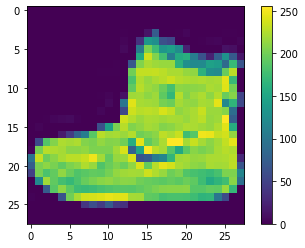

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

- 신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정합니다. 이렇게 하기 위해선 255로 나누어야 합니다. 
- 훈련 세트와 테스트 세트를 동일한 방식으로 전처리하는 것이 중요합니다:

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

- 훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 봅시다. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

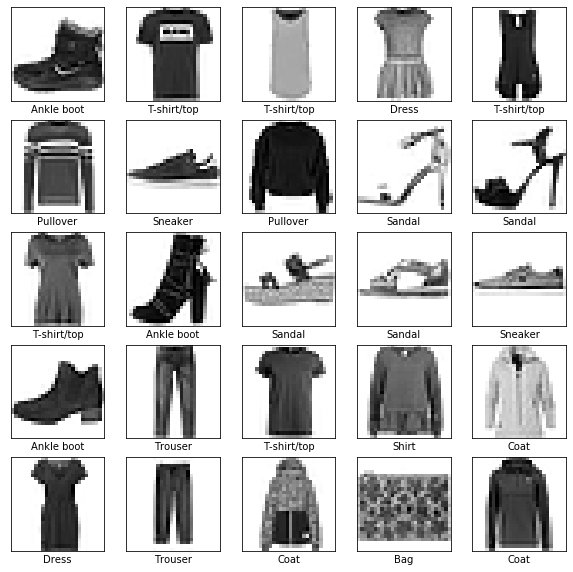

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 모델 구성

- 층 설정

신경망의 기본 빌딩 블록은 레이어 입니다. 레이어는 레이어에 공급된 데이터로부터 표현을 추출합니다. 이러한 표현은 당면한 문제에 의미가 있어야 합니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

이 네트워크의 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

### 모델 컴파일

#### 모델을 훈련할 준비가 되기 전에 몇 가지 설정이 더 필요합니다. 다음은 모델의 컴파일 단계에서 추가됩니다.

- 손실 함수 - 훈련 중 모델이 얼마나 정확한지 측정합니다. 모델을 올바른 방향으로 "조정"하려면 이 함수를 최소화해야 합니다.

- 옵티마이저 - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식입니다.

- 메트릭 — 훈련 및 테스트 단계를 모니터링하는 데 사용됩니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 훈련

#### 신경망 모델을 훈련하려면 다음 단계가 필요합니다.

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.

2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.

3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.

4. 예측이 test_labels 배열의 레이블과 일치하는지 확인합니다.

In [14]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.5023 - accuracy: 0.8229
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3755 - accuracy: 0.8616
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3353 - accuracy: 0.8777
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3117 - accuracy: 0.8856
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2932 - accuracy: 0.8921
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2790 - accuracy: 0.8961
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2661 - accuracy: 0.9002
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2562 - accuracy: 0.9042
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2467 - accuracy: 0.9081
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.237

### 정확도 평가

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3310 - accuracy: 0.8858

Test accuracy: 0.8858000040054321


### 예측하기

In [16]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [17]:
predictions = probability_model.predict(test_images)

In [18]:
predictions[0]

array([1.7325117e-05, 6.4250133e-10, 5.8987166e-07, 5.5070480e-08,
       1.3367988e-07, 2.5006437e-03, 3.5889834e-06, 2.7475962e-02,
       1.3320684e-07, 9.7000164e-01], dtype=float32)

In [19]:
np.argmax(predictions[0])

9

In [20]:
test_labels[0]

9

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 예측확인

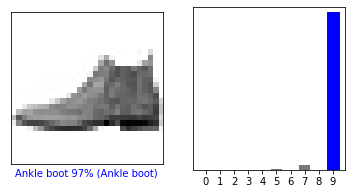

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


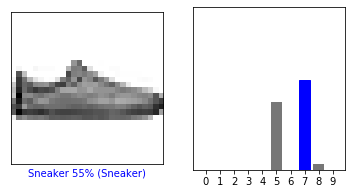

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

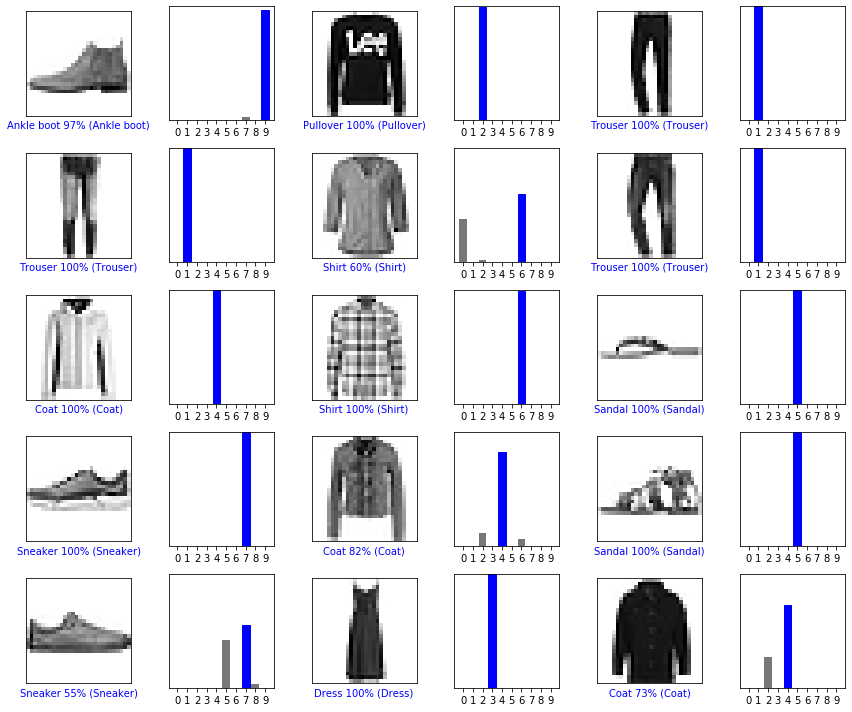

In [24]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### 훈련된 모델 사용하기

In [25]:
img = test_images[1]

print(img.shape)

(28, 28)


In [26]:
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [27]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[8.3335442e-05 1.0525507e-14 9.9527693e-01 6.8058419e-08 9.6516748e-04
  6.6843961e-12 3.6744997e-03 1.5835513e-13 1.1389979e-09 1.7113445e-18]]


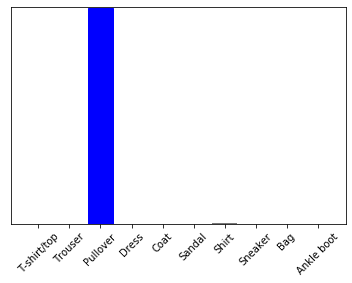

In [28]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

In [29]:
np.argmax(predictions_single[0])

2